![video decomposition clustering](https://raw.githubusercontent.com/ARVEST-APP/ml-notebooks/refs/heads/main/docs/images/notebooks/video-decomposiiton-clustering.png)

In this notebook, we shall start learning about the [Arvest](https://arvest.app/en) API and its [python package](https://github.com/ARVEST-APP/arvest-api) by taking some audiovisual IIIF Manifests sorted on Arvest, decomposing them into images, and using clustering and other machine learning techniques to create some interactive interfaces that we can upload and use in Arvest. 

# 0. Setup

Let's begin by installing and importing all of the different components we will need.

In [45]:
print("Installing and importing packages...")

# Uninstall and reinstall packages for a clean environment
!pip uninstall -q -y arvestapi
!pip uninstall -q -y arvesttools
!pip uninstall -q -y jhutils
!pip uninstall -q -y iiif_prezi3
!pip uninstall -q -y dvt
!pip install -q --disable-pip-version-check git+https://github.com/ARVEST-APP/arvest-api.git
!pip install -q --disable-pip-version-check git+https://github.com/ARVEST-APP/arvest-api-tools.git
!pip install -q --disable-pip-version-check git+https://github.com/jdchart/jh-py-utils.git
!pip install -q --disable-pip-version-check git+https://github.com/iiif-prezi/iiif-prezi3.git
!pip install -q --disable-pip-version-check git+https://github.com/distant-viewing/dvt.git
!pip install -q --disable-pip-version-check mediapipe
!pip install -q --disable-pip-version-check opencv-python
!pip install -q --disable-pip-version-check scikit-learn
!pip install -q --disable-pip-version-check matplotlib

# Import packages
import arvestapi
import arvesttools.manifest_creation
from jhutils.local_files import read_json, write_json, get_image_info, collect_files
import jhutils.online_files
from jhutils.misc import print_progress_bar, slugify
import os
import dvt
import iiif_prezi3
import shutil
import requests
import json
import cv2
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from PIL import Image
import random
import mimetypes
import mediapipe as mp

print("👍 Ready!")

Installing and importing packages...
👍 Ready!


### If you're following a workshop session...

If you're currently in a workshop - hello! 👋

You can run this cell to download all of the data into your colab session so that you don't have to run all of the time-consuming processes.

In [2]:
IM_IN_A_WORKSHOP = False

if IM_IN_A_WORKSHOP:
    print("Downloading data...")
    
    # Download and unpack zip:
    os.makedirs(os.path.join(os.getcwd(), "downloaded_data"), exist_ok=True)
    jhutils.online_files.download_zip("https://github.com/ARVEST-APP/arvest-workshops/raw/main/resources/workshop-dl-media.zip", os.path.join(os.getcwd(), "downloaded_data"))
    print("👍 Downloaded data")

## 1. Connect to Arvest

First, we need to "connect" to Arvest using the Arvest API package. For this, we need our user email and our password which we will give to an instance of the `arvestapi.Arvest()` class. For convenience, we've saved ours in a file which is why we get `LOGIN_DATA` by reading a json file.

In [3]:
# First, let's connect to our Arvest account:
LOGIN_DATA = os.path.join(os.getcwd(), "login_private.json")
credentials = read_json(LOGIN_DATA)

ar = arvestapi.Arvest(credentials["email"], credentials["password"])
print(f"👍 Succesfully connected to Arvest with \"{ar.profile.name}\"")

👍 Succesfully connected to Arvest with "ArvestTestUser0"


# 2. Get videos
First we will need some sources to process! In this example, we shall be comparing different productions of Pina Bausch's [_Café Müller_](https://en.wikipedia.org/wiki/Caf%C3%A9_M%C3%BCller).

It so happens that we have some video Manifests on our Arvest account. Let's get our Manifests using the Arvest API's `get_manifests()` function.

Once e have all of our Manifests, we can cycle through them, and check if each one is one of the Manifests that we're looking for. We know that our Manifest items have a specific description, so lets check that by inspecting the `description` property.

In [4]:
VIDEO_MANIFESTS = []

# Get all of our manifests:
manifests = ar.get_manifests()

# Get all of the manifests with a given description
for manifest in manifests:
    if manifest.description == "Café Müller video recording":
        VIDEO_MANIFESTS.append(manifest)

print(f"🔍 Found {len(VIDEO_MANIFESTS)} manifests.")

🔍 Found 7 manifests.


### Download the videos for processing

In order to process the videos we will need to be able to access them locally, which means that we will need to download them into our session. We can do this by getting the Manifest content, and then retrieving the `id` of the video of the first canvas.

ℹ️ This step will be skipped if you downloaded the workshop elements, however you cans till run the cell.

In [34]:
LOCAL_VIDEO_PATHS = {}

if not IM_IN_A_WORKSHOP:
    for i, manifest in enumerate(VIDEO_MANIFESTS):
        video_url = manifest.get_content()["items"][0]["items"][0]["items"][0]["body"]["id"]
        print_progress_bar(i + 1, len(VIDEO_MANIFESTS), f"(downloading {video_url})...")

        path = jhutils.online_files.download(video_url, dir = os.path.join(os.getcwd(), "data", "videos"))
        LOCAL_VIDEO_PATHS[slugify(manifest.get_content()["id"])] = {"path" : path, "manifest_path" : manifest.get_full_url()}
else:
    LOCAL_VIDEO_PATHS = {} # ADD THIS

print(f"👍 Downloaded videos")

|██████████████████████████████████████████████████| 100.0% Complete (downloading https://peertube.arvest.app/w/54WW6TQgD3CmZY6W8uQCsd)...
👍 Downloaded videos


## 3. Extract images

We're going to process one image for every second of video in order to get a good idea about the visual composition of each video. To do this we'll first need to extract images from the videos.

ℹ️ This step will be skipped if you downloaded the workshop elements, however you cans till run the cell.

In [35]:
LOCAL_IMAGE_PATHS = []
INTERVAL = 2
img_count = 0
out_folder = os.path.join(os.getcwd(), "data", "images")
os.makedirs(out_folder, exist_ok=True)

if not IM_IN_A_WORKSHOP:
    for i, video_name in enumerate(LOCAL_VIDEO_PATHS):
        print_progress_bar(i + 1, len(LOCAL_VIDEO_PATHS), f"(treating {video_name})...")

        # Open video file with opencv 2 and get properties
        cap = cv2.VideoCapture(LOCAL_VIDEO_PATHS[video_name]["path"])
        fps = cap.get(cv2.CAP_PROP_FPS)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        duration = total_frames / fps

        # For iteration:
        frame_interval = int(fps * INTERVAL)
        frame_num = 0
        saved_frame_count = 0

        while frame_num < total_frames:
            # Get frame
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
            ret, frame = cap.read()
            if not ret:
                break
            
            # Save image
            timestamp_secs = frame_num / fps
            output_path = os.path.join(out_folder, f"img_{img_count:04d}.jpg")
            cv2.imwrite(output_path, frame)
            LOCAL_IMAGE_PATHS.append({"img_path" : output_path, "index" : img_count, "frame" : saved_frame_count, "time" : timestamp_secs, "video_name" : video_name})

            img_count = img_count + 1

            saved_frame_count += 1
            frame_num += frame_interval

        cap.release()
else:
    LOCAL_IMAGE_PATHS = [] # ADD THIS

print(f"🏞️ Finished extracting {img_count} images!")

|██████████████████████████████████████████████████| 100.0% Complete (treating https-raw-githubusercontent-com-arvest-app-arvest-workshops-refs-heads-main-resources-manifests-videos-scene-b-2024-json)...on)...
🏞️ Finished extracting 218 images!


# 4. Process embeddings
Next we can use the [distant viewing toolkit](https://github.com/distant-viewing/dvt) to map the images within an embedding space. 

We'll save the embedding data as a **numpy file** (`.npy`) so that we don't have to run this step again.

ℹ️ If you are running this for the first time dvt it will download the model onto your computer.

ℹ️ This step will be skipped if you downloaded the workshop elements, however you cans till run the cell.

In [12]:
print("Processing...")

# Instance of dvt AnnoEmbed class:
embedder = dvt.AnnoEmbed()

if not IM_IN_A_WORKSHOP:
    first_time = True

    for i, image in enumerate(LOCAL_IMAGE_PATHS):
        print_progress_bar(i + 1, len(LOCAL_IMAGE_PATHS), f"(treating {os.path.basename(image['img_path'])})...")

        image_as_np = cv2.imread(image['img_path'])
        image_as_np = cv2.cvtColor(image_as_np, cv2.COLOR_BGR2RGB)

        embedding = embedder.run(image_as_np)["embedding"]
        if first_time:
            embedding_list = embedding
            first_time = False
        else:
            embedding_list = np.vstack((embedding_list, embedding))

    embedding_file = os.path.join(os.getcwd(), "data", "embeddings.npy")
    np.save(embedding_file, embedding_list)

print("👍 Finished collecting embeddings!")

Processing...
|██████████████████████████████████████████████████| 100.0% Complete (treating img_0217.jpg)...
👍 Finished collecting embeddings!


# 3. Dimensionality reduction and clustering
Now that we have our embedding data, we can use dimensionality reduction to crunch all of these dimensions down into 2 so that they can be projected into a 2-dimensional space. 

To do this, we'll use the dimensionality reduction algorithm [T-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding). 

Note that we also do some pre- and post-processing, the full process is: standardisation -> dimensionality reduction -> normalization.

In [13]:
if not IM_IN_A_WORKSHOP:
    embedding_file = os.path.join(os.getcwd(), "data", "embeddings.npy")
else:
    embedding_file = "" # ADD THIS
    
embedding_list = np.load(embedding_file)

standardized = StandardScaler().fit_transform(embedding_list)

tsne = TSNE(n_components = 2, perplexity = 50, learning_rate=200, n_iter=5000)
reduced = tsne.fit_transform(standardized)

normalized = MinMaxScaler((0, 1)).fit_transform(reduced)

/Users/jacob/Documents/Repos/ARVEST-APP/ml-notebooks/venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


If we like, we can visualize the data in a scatter plot:

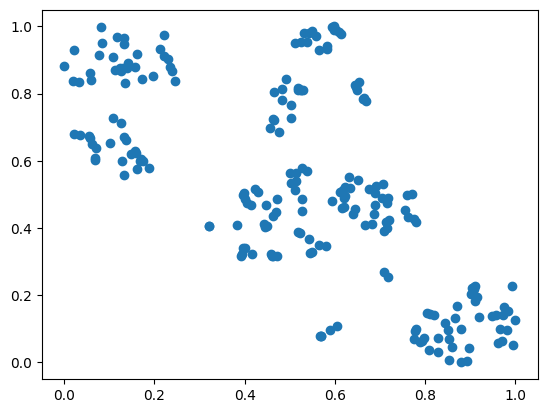

In [14]:
transposed = np.transpose(normalized)
plt.scatter(transposed[0], transposed[1])
plt.show()

## Clustering (optional)

Next we can perform some clustering on this data using [K-Means](https://en.wikipedia.org/wiki/K-means_clustering).

This will allow us to create subcategories.

In [15]:
NUM_CLUSTERS = 6

kmeans = KMeans(n_clusters = NUM_CLUSTERS, random_state = 0, n_init = "auto")
clusters = kmeans.fit(normalized).labels_

# Create a random colour map for visualisation:
colour_map = {}
used = []
for item in clusters:
    if item not in used:
        colour_map[str(item)] = (random.random(), random.random(), random.random())
        used.append(item)

We can visualize the clusters in a scatter plot like this:

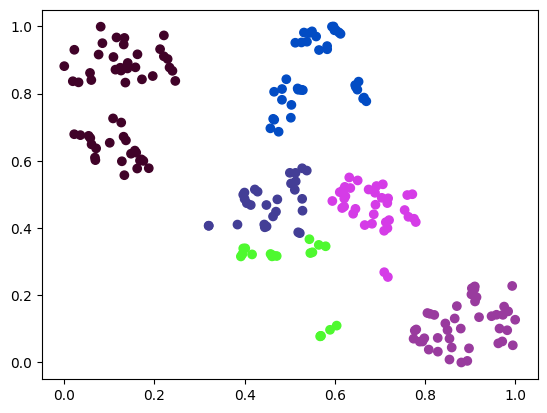

In [16]:
transposed = np.transpose(normalized)
col = []
for item in clusters:
    col.append(colour_map[str(item)])

plt.scatter(transposed[0], transposed[1], c = col)
plt.show()

# 4. Export to Arvest
Finally, we shall export the results of our analysis to an image file, and create an annotated (and therefore interactive) IIIF Manifest that can be consulted in [Arvest](https://arvest.app/en). 

First, we shall create a high-res PNG file that projects the corresponding images into the 2D space of the dimensionality reduction. 

We shall also keep a track of the coordinates so that we can create our annotations later.

In [38]:
IMAGE_PATH = os.path.join(os.getcwd(), "data", "visualization-image.png")
COORDINATES_PATH = os.path.join(os.getcwd(), "data", "visualization-coordinates.json")

WIDTH = 6000
HEIGHT = 6000
PADDING = 100
IMAGE_ZOOM = 0.08

def scale(val, old_min, old_max, new_min, new_max):
    return new_min + (((val - old_min) * (new_max - new_min)) / (old_max - old_min))

# Function for adding each image to the main image:
def add_image(full_image, coordinates_list, img_path, coordinates, manifest, time):
  img_data = get_image_info(img_path)
  this_img = Image.open(img_path)

  w = int(img_data["width"] * IMAGE_ZOOM)
  h = int(img_data["height"] * IMAGE_ZOOM)
  x = int(scale(int(int(float(coordinates[0]) * WIDTH) - (w * 0.5)), 0, WIDTH, PADDING, WIDTH - (PADDING * 2)))
  y = int(scale(int(int(float(coordinates[1]) * HEIGHT) - (h * 0.5)), 0, HEIGHT, PADDING, HEIGHT - (PADDING * 2)))

  this_img = this_img.resize((w, h))
  full_image.paste(this_img, (x, y))

  coordinates_list.append({"url" : manifest, "x" : x, "y" : y, "w" : w, "h" : h, "img_path" : os.path.basename(img_path), "time" : time})

# Initialize image and coordinates
full_image = Image.new('RGBA', (WIDTH, HEIGHT))
coordinates = {"images" : []}

# Add all of the images:
for i, item in enumerate(normalized):
  image_data = LOCAL_IMAGE_PATHS[i]
  print_progress_bar(i + 1, len(LOCAL_IMAGE_PATHS), f"Treating {image_data['img_path']}")

  add_image(full_image, coordinates["images"], image_data['img_path'], item, LOCAL_VIDEO_PATHS[image_data['video_name']]["manifest_path"], image_data['time'])

full_image.save(IMAGE_PATH)
write_json(COORDINATES_PATH, coordinates)

print("🎨 Image created!")

|██████████████████████████████████████████████████| 100.0% Complete Treating /Users/jacob/Documents/Repos/ARVEST-APP/ml-notebooks/_local/workflows/distant-viewing/03-Video-Decomposition-Clustering/data/images/img_0217.jpg
🎨 Image created!


### Upload image to Arvest
Let's use the `add_media()` function to upload a local image to Arvest.

In [43]:
added_media = ar.add_media(path = IMAGE_PATH)
added_media.update_title("Pina Bausch recordings projection")
added_media.update_description("A projection in 2D space of Pina Bausch recordings.")

print(f"👍 Media uploaded to Arvest at the following url: {added_media.get_full_url()}")

👍 Media uploaded to Arvest at the following url: https://resource.arvest.app/c5a604fb933bdbac44476da1f4acd98115cb9e79/visualization-image.png


### Create and upload Manifest

Now let's create the Manifest. We'll use the [arvestapitools](https://github.com/ARVEST-APP/arvest-api-tools) `media_to_manifest()` utility function, which can take an Arvest media item and create a Manifest from it.

Once we've created the Manifest, we can add annotations to render it interactive. We'll add an annotation for each of the images with the `add_textual_annotation()` function with the corresponding video Manifest url and spatial position and dimensions:

In [ ]:
# Create the Manifest:
manifest = arvesttools.manifest_creation.media_to_manifest(added_media)

# Add an annotation for each Manifest:
for item in coordinates["images"]:
    manifest_url = item["url"]
    xywh = {"x" : item["x"], "y" : item["y"], "w" : item["w"], "h" : item["h"]}
    
    arvesttools.manifest_creation.add_textual_annotation(
        manifest,
        text_content = f"<p><strong>{item['img_path']}</strong><br><i>{item['time']} seconds</i></p>",
        xywh = xywh,
        linked_manifest = manifest_url
    )

# Save to disk:
local_path = os.path.join(os.getcwd(), "data", "projection-manifest.json")
write_json(local_path, manifest.dict())

# And upload to Arvest:
added_manifest = ar.add_manifest(path = local_path, update_id = True)
added_manifest.update_title("Image embedding projection")
added_manifest.update_description("Projection of a collection of images in 2-D space.")
added_manifest.update_thumbnail_url(added_media.thumbnail_url)

print(f"👍 Manifest uploaded to Arvest at the following url: {added_manifest.get_preview_url()}")

👍 Manifest uploaded to Arvest at the following url: https://workspace.arvest.app/manifest/c7ae0110b387f1f6c440fa11e508880154d95e1c/projection-manifest.json


## 5. Pose detection
Now that we've made this initial interface, we can see that the image embeddings as a feature set mainly produce a projection that groups images together by recording. We need to rethink what it is that we are trying to find in our data.

In the context of dance analysis, it could be interesting to project images ccording to post detection data. In this first cell we set up some utility functions for this:

In [80]:
# Initialize MediaPipe
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
pose = mp_pose.Pose(static_image_mode=True)

def normalize_landmarks(landmarks):
    # Get key landmarks
    left_hip = landmarks[mp_pose.PoseLandmark.LEFT_HIP.value]
    right_hip = landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value]
    left_shoulder = landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value]
    right_shoulder = landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value]

    # Calculate hip center
    hip_center = np.array([(left_hip.x + right_hip.x) / 2,
                           (left_hip.y + right_hip.y) / 2,
                           (left_hip.z + right_hip.z) / 2])

    # Translate landmarks to hip center
    translated = []
    for lm in landmarks:
        translated.append(np.array([lm.x, lm.y, lm.z]) - hip_center)

    # Calculate torso length
    shoulder_center = (np.array([left_shoulder.x, left_shoulder.y, left_shoulder.z]) +
                       np.array([right_shoulder.x, right_shoulder.y, right_shoulder.z])) / 2
    torso_length = np.linalg.norm(shoulder_center - hip_center)

    # Scale landmarks
    normalized = [coords / torso_length for coords in translated]

    return normalized

def angle_between(v1, v2):
    v1 = v1 / np.linalg.norm(v1)
    v2 = v2 / np.linalg.norm(v2)
    dot = np.clip(np.dot(v1, v2), -1.0, 1.0)
    return np.arccos(dot)

def compute_joint_angles(landmarks):
    def get_point(idx): return np.array([landmarks[idx].x, landmarks[idx].y, landmarks[idx].z])

    angles = []

    # Left elbow
    shoulder = get_point(mp_pose.PoseLandmark.LEFT_SHOULDER.value)
    elbow = get_point(mp_pose.PoseLandmark.LEFT_ELBOW.value)
    wrist = get_point(mp_pose.PoseLandmark.LEFT_WRIST.value)
    angles.append(angle_between(shoulder - elbow, wrist - elbow))

    # Right elbow
    shoulder = get_point(mp_pose.PoseLandmark.RIGHT_SHOULDER.value)
    elbow = get_point(mp_pose.PoseLandmark.RIGHT_ELBOW.value)
    wrist = get_point(mp_pose.PoseLandmark.RIGHT_WRIST.value)
    angles.append(angle_between(shoulder - elbow, wrist - elbow))

    # Add more joints as needed

    return angles

def flatten_visible_keypoints(landmarks, visibility_threshold=0.5):
    keypoints = []
    for lm in landmarks:
        if lm.visibility > visibility_threshold:
            keypoints.extend([lm.x, lm.y, lm.z, lm.visibility])
        else:
            # Optional: fill with zeros or skip
            keypoints.extend([0, 0, 0, 0])
    return keypoints

def draw_pose_on_transparent(image_shape, landmarks):
    height, width = image_shape[:2]

    # Step 1: Draw pose on white background (3-channel BGR)
    white_bg = np.ones((height, width, 3), dtype=np.uint8) * 255

    mp_drawing.draw_landmarks(
        white_bg,
        landmarks,
        mp_pose.POSE_CONNECTIONS,
        mp_drawing.DrawingSpec(color=(0, 0, 0), thickness=2, circle_radius=2),
        mp_drawing.DrawingSpec(color=(0, 0, 0), thickness=2)
    )

    # Step 2: Convert white to transparent
    white_pixels = np.all(white_bg == [255, 255, 255], axis=-1)
    alpha_channel = np.where(white_pixels, 0, 255).astype(np.uint8)

    rgba = cv2.cvtColor(white_bg, cv2.COLOR_BGR2BGRA)
    rgba[..., 3] = alpha_channel

    return rgba

I0000 00:00:1747990735.563156 19742878 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 83.1), renderer: Apple M2


W0000 00:00:1747990735.643831 20211520 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747990735.653463 20211523 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Here we run the pose detection analysis. We follow these steps:

- perform analysis
- normalize poses (remove translation and scale differences between poses by using the hip center as an origin and torso length or scaling)
- Use angles between joins as features
- make sure that we're only treating poses where a certain amount of keypoints were visible.

In [ ]:
IMAGES_TO_ANALYSE = collect_files(os.path.join(os.getcwd(), "data", "images"), ["jpg"])
OUTPUT_FULL_IMAGE = False
OUTPUT_FOLDER = os.path.join(os.getcwd(), "data", "images", "pose_detection")

os.makedirs(OUTPUT_FOLDER, exist_ok = True)

# Step 1: Extract pose features
filenames = []
features = []
images = []
landmarks_list = []

for i, filename in enumerate(IMAGES_TO_ANALYSE):
    print_progress_bar(i + 1, len(IMAGES_TO_ANALYSE), f"(treating {os.path.basename(filename)})")

    image_path = filename

    filename = os.path.basename(filename)
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)

    if results.pose_landmarks:
        landmarks = results.pose_landmarks.landmark
        normalized_landmarks = normalize_landmarks(landmarks)
        angles = compute_joint_angles(landmarks)
        flattened = flatten_visible_keypoints(landmarks)

        features.append(flattened)
        images.append(image)
        landmarks_list.append(results.pose_landmarks)
        filenames.append(os.path.basename(filename))

        if OUTPUT_FULL_IMAGE:
            output_image = image.copy()
            mp_drawing.draw_landmarks(
                output_image,
                results.pose_landmarks,
                mp_pose.POSE_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2),
                mp_drawing.DrawingSpec(color=(0, 0, 255), thickness=2)
            )
            cv2.imwrite(os.path.join(OUTPUT_FOLDER, f"{os.path.splitext(os.path.basename(filename))[0]}.png"), output_image)
        else:
            pose_image = draw_pose_on_transparent(image.shape, results.pose_landmarks)
            cv2.imwrite(os.path.join(OUTPUT_FOLDER, f"{os.path.splitext(os.path.basename(filename))[0]}.png"), pose_image)

pose.close()
features_array = np.array(features)

print(f"👍 Finished! Final corpus is comprised of {len(features_array)} items.")

|██████████████████████████████████████████████████| 100.0% Complete (treating img_0019.jpg)
👍 Finished! Final corpus is comprised of 163 items.


/Users/jacob/Documents/Repos/ARVEST-APP/ml-notebooks/venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


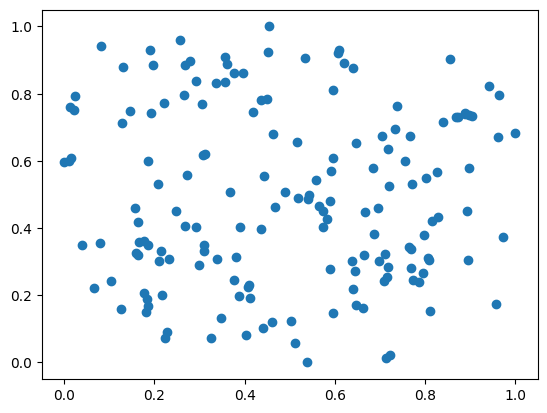

In [82]:
standardized = StandardScaler().fit_transform(features_array)

tsne = TSNE(n_components = 2, perplexity = 50, learning_rate=200, n_iter=5000)
reduced = tsne.fit_transform(standardized)

normalized = MinMaxScaler((0, 1)).fit_transform(reduced)

transposed = np.transpose(normalized)
plt.scatter(transposed[0], transposed[1])
plt.show()

Now, like before, we can create an intractive visualization. Let's start by making the image:

In [91]:
IMAGE_PATH = os.path.join(os.getcwd(), "data", "pose-detection-visualization-image.png")
COORDINATES_PATH = os.path.join(os.getcwd(), "data", "pose-detection-visualization-coordinates.json")

WIDTH = 6000
HEIGHT = 6000
PADDING = 100
IMAGE_ZOOM = 0.2

def scale(val, old_min, old_max, new_min, new_max):
    return new_min + (((val - old_min) * (new_max - new_min)) / (old_max - old_min))

# Function for adding each image to the main image:
def add_image(full_image, coordinates_list, img_path, coordinates, manifest, time):
  img_data = get_image_info(img_path)
  this_img = Image.open(img_path).convert("RGBA")  # Ensure RGBA

  w = int(img_data["width"] * IMAGE_ZOOM)
  h = int(img_data["height"] * IMAGE_ZOOM)
  x = int(scale(int(int(float(coordinates[0]) * WIDTH) - (w * 0.5)), 0, WIDTH, PADDING, WIDTH - (PADDING * 2)))
  y = int(scale(int(int(float(coordinates[1]) * HEIGHT) - (h * 0.5)), 0, HEIGHT, PADDING, HEIGHT - (PADDING * 2)))

  this_img = this_img.resize((w, h), resample=Image.LANCZOS)

  # Create a transparent image same size as full_image
  temp_img = Image.new("RGBA", full_image.size, (0, 0, 0, 0))
  temp_img.paste(this_img, (x, y), mask=this_img)  # Use self as mask for alpha paste

  # Composite with existing image
  full_image.alpha_composite(temp_img)

  coordinates_list.append({"url": manifest,"x": x,"y": y,"w": w,"h": h,"img_path": os.path.basename(img_path),"time": time})

# Initialize image and coordinates
full_image = Image.new('RGBA', (WIDTH, HEIGHT))
coordinates = {"images" : []}

pose_images = collect_files(OUTPUT_FOLDER, ["png"])

# Add all of the images:
for i, pose_image_path in enumerate(pose_images):
   print_progress_bar(i + 1, len(pose_images), f"Treating {pose_image_path}")

   real_index = int(pose_image_path.split(f"{OUTPUT_FOLDER}/img_")[1].split(".png")[0])
   image_data = LOCAL_IMAGE_PATHS[real_index]
   item = normalized[i]

   add_image(full_image, coordinates["images"], pose_image_path, item, LOCAL_VIDEO_PATHS[image_data['video_name']]["manifest_path"], image_data['time'])

full_image.save(IMAGE_PATH)
write_json(COORDINATES_PATH, coordinates)

print("🎨 Image created!")

|██████████████████████████████████████████████████| 100.0% Complete Treating /Users/jacob/Documents/Repos/ARVEST-APP/ml-notebooks/_local/workflows/distant-viewing/03-Video-Decomposition-Clustering/data/images/pose_detection/img_0019.png
🎨 Image created!


Now we can upload the image in the same way as before:

In [92]:
added_media = ar.add_media(path = IMAGE_PATH)
added_media.update_title("Pina Bausch pose detection projection")
added_media.update_description("A projection in 2D space of Pina Bausch pose detections.")

print(f"👍 Media uploaded to Arvest at the following url: {added_media.get_full_url()}")

👍 Media uploaded to Arvest at the following url: https://resource.arvest.app/07c6a8f8b0145463e1abb34c3d7e6c60639bf777/pose-detection-visualization-image.png


And finally create the Manifest:

In [93]:
# Create the Manifest:
manifest = arvesttools.manifest_creation.media_to_manifest(added_media)

# Add an annotation for each Manifest:
for item in coordinates["images"]:
    manifest_url = item["url"]
    xywh = {"x" : item["x"], "y" : item["y"], "w" : item["w"], "h" : item["h"]}
    
    arvesttools.manifest_creation.add_textual_annotation(
        manifest,
        text_content = f"<p><strong>{item['img_path']}</strong><br><i>{item['time']} seconds</i></p>",
        xywh = xywh,
        linked_manifest = manifest_url
    )

# Save to disk:
local_path = os.path.join(os.getcwd(), "data", "projection-manifest.json")
write_json(local_path, manifest.dict())

# And upload to Arvest:
added_manifest = ar.add_manifest(path = local_path, update_id = True)
added_manifest.update_title("Pose detection projection")
added_manifest.update_description("Projection of a collection of pose detections in 2-D space.")
added_manifest.update_thumbnail_url(added_media.thumbnail_url)

print(f"👍 Manifest uploaded to Arvest at the following url: {added_manifest.get_preview_url()}")

👍 Manifest uploaded to Arvest at the following url: https://workspace.arvest.app/manifest/48d82fe718388dcbef892c55a4a6786cb76b5e1f/projection-manifest.json
